<a href="https://colab.research.google.com/github/Zarthan66/GoogleCollab/blob/main/AsciiArt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ascii Art with DeepLabV3 Image Segmentation**

# Getting Data

In [5]:
import cv2
import torch
import numpy as np

from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt
from IPython.display import Image
from google.colab import files
from google.colab.patches import cv2_imshow
from urllib.request import urlretrieve

# change the link for your own image
# the result are better with clear background and there is person on it
urlretrieve('https://www.w3schools.com/html/img_girl.jpg', '/content/profile.jpg')
img = cv2.imread('/content/profile.jpg')

Create 2 different version of your image with lower resolution. So you can compare them later

In [3]:
# resizing image into a half while keeping its ratio
def resizeToHalf(img, check = False):
  height, width = img.shape[:2]
  newWidth = int(width / 2)
  # Determine its landscape, potrait, etc
  if width < height:
    newHeight = int((height / width) * newWidth)
  elif width > height:
    newHeight = int((width / height) * newWidth)
  else:
    newHeight = int(height / 2)
  
  return cv2.resize(img, (newWidth, newHeight)) 

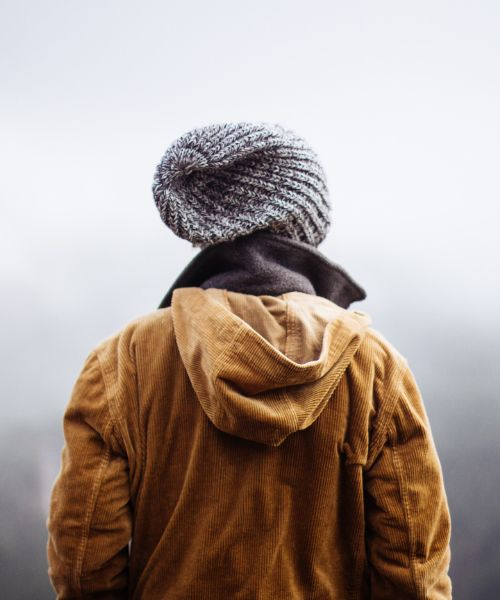

Height: 600
Width: 500


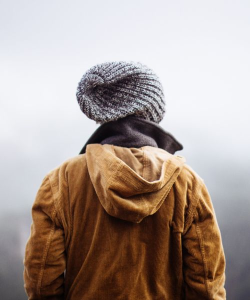

Height: 300
Width: 250


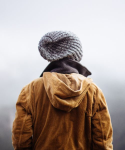

Height: 150
Width: 125


In [4]:
# Importing Image module from PIL package 
from PIL import Image 
import PIL 

imgLowRes = resizeToHalf(img)
imgVeryLowRes = resizeToHalf(imgLowRes)
  
# save images using extension
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
Image.fromarray(imgRGB).save("/content/profile.jpg")
imgLowRGB = cv2.cvtColor(imgLowRes, cv2.COLOR_BGR2RGB)
Image.fromarray(imgLowRGB).save("/content/profileLow.jpg")
imgVeryLowRGB = cv2.cvtColor(imgVeryLowRes, cv2.COLOR_BGR2RGB)
Image.fromarray(imgVeryLowRGB).save("/content/profileVeryLow.jpg")

# Get resolution
height, width = img.shape[:2]
heightLowRes, widthLowRes = imgLowRes.shape[:2]
heightVeryLowRes, widthVeryLowRes = imgVeryLowRes.shape[:2]

cv2_imshow(img)
print("Height: " + str(height))
print("Width: " + str(width))
cv2_imshow(imgLowRes)
print("Height: " + str(heightLowRes))
print("Width: " + str(widthLowRes))
cv2_imshow(imgVeryLowRes)
print("Height: " + str(heightVeryLowRes))
print("Width: " + str(widthVeryLowRes))

# Using the Model

Functions that we will use to remove the background

In [6]:
import cv2
import torch
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt

def load_model():
  model = torch.hub.load('pytorch/vision:v0.6.0', 'deeplabv3_resnet101', pretrained=True)
  model.eval()
  return model

def make_transparent_foreground(pic, mask):
  # split the image into channels
  b, g, r = cv2.split(np.array(pic).astype('uint8'))
  # add an alpha channel with and fill all with transparent pixels (max 255)
  a = np.ones(mask.shape, dtype='uint8') * 255
  # merge the alpha channel back
  alpha_im = cv2.merge([b, g, r, a], 4)
  # create a transparent background
  bg = np.zeros(alpha_im.shape)
  # setup the new mask
  new_mask = np.stack([mask, mask, mask, mask], axis=2)
  # copy only the foreground color pixels from the original image where mask is set
  foreground = np.where(new_mask, alpha_im, bg).astype(np.uint8)

  return foreground

def remove_background(model, input_file):
  input_image = Image.open(input_file)
  preprocess = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

  # move the input and model to GPU for speed if available
  if torch.cuda.is_available():
      input_batch = input_batch.to('cuda')
      model.to('cuda')

  with torch.no_grad():
      output = model(input_batch)['out'][0]
  output_predictions = output.argmax(0)

  # create a binary (black and white) mask of the profile foreground
  mask = output_predictions.byte().cpu().numpy()
  background = np.zeros(mask.shape)
  bin_mask = np.where(mask, 255, background).astype(np.uint8)

  foreground = make_transparent_foreground(input_image ,bin_mask)

  return foreground, bin_mask

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Text(0.5, 1.0, 'Very Low Resolution')

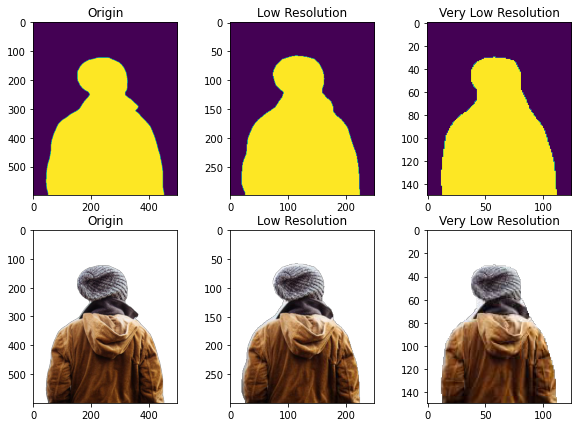

In [7]:
import numpy as np
deeplab_model = load_model()

foreground, binMask = remove_background(deeplab_model, '/content/profile.jpg')
foregroundLow, binMaskLow = remove_background(deeplab_model, '/content/profileLow.jpg')
foregroundVeryLow, binMaskVeryLow = remove_background(deeplab_model, '/content/profileVeryLow.jpg')

# create figure
fig = plt.figure(figsize=(10, 7))

# Adds a subplot at the 1st position
fig.add_subplot(2, 3, 1)
plt.imshow(binMask)
plt.title("Origin")

fig.add_subplot(2, 3, 2)
plt.imshow(binMaskLow)
plt.title("Low Resolution")

fig.add_subplot(2, 3, 3)
plt.imshow(binMaskVeryLow)
plt.title("Very Low Resolution")

# Adds a subplot at the 1st position
fig.add_subplot(2, 3, 4)
plt.imshow(foreground)
plt.title("Origin")

fig.add_subplot(2, 3, 5)
plt.imshow(foregroundLow)
plt.title("Low Resolution")

fig.add_subplot(2, 3, 6)
plt.imshow(foregroundVeryLow)
plt.title("Very Low Resolution")

In [8]:
# Saving the foreground images
Image.fromarray(foreground).save("/content/foreground.png")
Image.fromarray(foregroundLow).save("/content/foregroundLow.png")
Image.fromarray(foregroundVeryLow).save("/content/foregroundVeryLow.png")

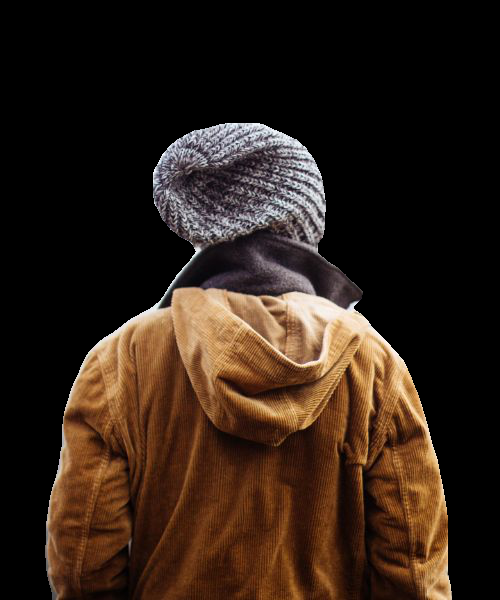

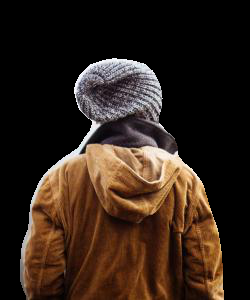

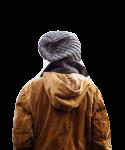

In [9]:
imgForeground = cv2.imread("/content/foreground.png")
imgForegroundLow = cv2.imread("/content/foregroundLow.png")
imgForegroundVeryLow = cv2.imread("/content/foregroundVeryLow.png")
cv2_imshow(imgForeground)
cv2_imshow(imgForegroundLow)
cv2_imshow(imgForegroundVeryLow)

# Applying Ascii Filter

In [15]:
def AsciiFilter(imgForeground, fileName = "result.txt"):
  # default 
  density = " _.,-=+:;cba!?0123456789$#@NM"

  # Less detailed ascii, better for Anime, cartoon, etc
  #density = "                              _.,-=+:;cba!?0123456789$#@NM"

  # Get width and height
  height, width = imgForeground.shape[:2]

  # Convert it to grayscale
  gray = cv2.cvtColor(imgForeground, cv2.COLOR_BGR2GRAY)

  f = open(fileName, "w")
  text = ""

  for i in range(height):
    for j in range(width):
      charIndex = int((gray[i,j] / 255) * len(density))
      if charIndex >= 0 and charIndex < len(density):
        text = text + density[charIndex]
    f.write(text + '\n')
    text = ""
  f.close()

In [16]:
AsciiFilter(imgForeground, "result.txt")
AsciiFilter(imgForegroundLow, "resultLow.txt")
AsciiFilter(imgForegroundVeryLow, "resultVeryLow.txt")

The result is stored on text file. Remember, with huge resolution, you need to zoom out to see the result. Another than that, its better to use dark background (dark mode) on text editor. To download the result, just run the code below. ⬇

In [17]:
# Native resolution
files.download("result.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
# Lower resolution (1/2)
files.download("resultLow.txt") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
# Very low resolution (1/4)
files.download("resultVeryLow.txt") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## As always, thanks for try the code :D